<a href="https://colab.research.google.com/github/skywalker00001/ACV/blob/main/face_parsing1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Version1.1

# Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')
ROOT = 'drive/MyDrive/ACV/Project1'

Mounted at /content/drive


In [2]:
# Checking out the GPU we have access to. This is output is from the google colab version. 
!nvidia-smi

Sat Mar 19 22:06:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install wandb -qqq
import wandb

     |████████████████████████████████| 1.7 MB 5.1 MB/s 
     |████████████████████████████████| 144 kB 64.2 MB/s 
     |████████████████████████████████| 181 kB 64.4 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 


In [4]:
# Login to wandb to log the model run and all the parameters
# 7229adacb32965027d73056a6927efd0365a00bc
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
wandb.login()

wandb: Currently logged in as: skywalk3r (use `wandb login --relogin` to force relogin)


True

In [6]:
#import wandb
import random
import numpy as np
import os
from tqdm import tqdm
from PIL import Image

import torch, torchvision
import torch.nn as nn
import torchvision.transforms as T
from torch import cuda
from torch.utils.data import Dataset, DataLoader


In [7]:
# # Setting up the device for GPU usage

DEVICE = 'cuda' if cuda.is_available() else 'cpu'
print("DEVICE is: ", DEVICE)

# Set random seeds and deterministic pytorch for reproducibility
SEED = 42
torch.manual_seed(SEED) # pytorch random seed
np.random.seed(SEED) # numpy random seed
torch.backends.cudnn.deterministic = True

DEVICE is:  cuda


# Utils

In [15]:
def cross_entropy2d(input, target, weight=None, size_average=True):
    n, c, h, w = input.size()
    nt, ht, wt = target.size()

    # Handle inconsistent size between input and target
    if h != ht or w != wt:
        input = nn.functional.interpolate(input, size=(ht, wt), mode="bilinear", align_corners=True)

    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    target = target.view(-1)
    loss = nn.functional.cross_entropy(
        input, target, weight=weight, size_average=size_average, ignore_index=250
    )
    return loss

# predict, groundtruth are both [batch, imsize, imsize]
def get_miou(predict, groundtruth, num_classes=19, smoothing=1e-6):
    pred = predict.to('cpu')
    grdth = groundtruth.to('cpu')
    miou_sum = 0
    batch = predict.size()[0]
    for idx in range(batch):
        area_intersect_all = torch.zeros(num_classes).to('cpu')
        area_union_all = torch.zeros(num_classes).to('cpu')
        for cls_idx in range(num_classes):
            area_intersect = torch.sum((pred[idx] == grdth[idx]) * (pred[idx] == cls_idx))
            area_pred_label = torch.sum(pred[idx] == cls_idx)
            area_gt_label = torch.sum(grdth[idx] == cls_idx)
            area_union = area_pred_label + area_gt_label - area_intersect

            area_intersect_all[cls_idx] += area_intersect + smoothing
            area_union_all[cls_idx] += area_union + smoothing

        iou_all = area_intersect_all / area_union_all * 100.0
        miou = iou_all.mean()

        miou_sum += miou

    return miou_sum

In [179]:
def uint82bin(n, count=8):
    """returns the binary of integer n, count refers to amount of bits"""
    return ''.join([str((n >> y) & 1) for y in range(count-1, -1, -1)])

def labelcolormap(N):
    if N == 19: # CelebAMask-HQ
        cmap = np.array([(0,  0,  0), (204, 0,  0), (76, 153, 0),
                     (204, 204, 0), (51, 51, 255), (204, 0, 204), (0, 255, 255),
                     (51, 255, 255), (102, 51, 0), (255, 0, 0), (102, 204, 0),
                     (255, 255, 0), (0, 0, 153), (0, 0, 204), (255, 51, 153), 
                     (0, 204, 204), (0, 51, 0), (255, 153, 51), (0, 204, 0)], 
                     dtype=np.uint8) 
    else:
        cmap = np.zeros((N, 3), dtype=np.uint8)
        for i in range(N):
            r, g, b = 0, 0, 0
            id = i
            for j in range(7):
                str_id = uint82bin(id)
                r = r ^ (np.uint8(str_id[-1]) << (7-j))
                g = g ^ (np.uint8(str_id[-2]) << (7-j))
                b = b ^ (np.uint8(str_id[-3]) << (7-j))
                id = id >> 3
            cmap[i, 0] = r
            cmap[i, 1] = g
            cmap[i, 2] = b
    return cmap

class Colorize(object):
    def __init__(self, n=19):
        self.cmap = labelcolormap(n)
        self.cmap = torch.from_numpy(self.cmap[:n])

    def __call__(self, gray_image):
        size = gray_image.size()
        color_image = torch.ByteTensor(3, size[1], size[2]).fill_(0)

        for label in range(0, len(self.cmap)):
            mask = (label == gray_image[0]).cpu()
            color_image[0][mask] = self.cmap[label][0]
            color_image[1][mask] = self.cmap[label][1]
            color_image[2][mask] = self.cmap[label][2]

        return color_image

def tensor2label(label_tensor, n_label):
    if n_label == 0:
        return None
    label_tensor = label_tensor.cpu().float()
    if label_tensor.size()[0] > 1:
        label_tensor = label_tensor.max(0, keepdim=True)[1]
    label_tensor = Colorize(n_label)(label_tensor)
    #label_numpy = np.transpose(label_tensor.numpy(), (1, 2, 0))
    label_numpy = label_tensor.numpy()
    label_numpy = label_numpy / 255.0

    return label_numpy

def generate_label(inputs, imsize):
    pred_batch = []
    for input in inputs:
        print('inputshape: ', input.shape)
        input = input.view(1, 19, imsize, imsize)
        pred = np.squeeze(input.data.max(1)[1].cpu().numpy(), axis=0)
        pred_batch.append(pred)

    pred_batch = np.array(pred_batch)
    pred_batch = torch.from_numpy(pred_batch)
            
    label_batch = []
    for p in pred_batch:
        p = p.view(1, imsize, imsize)
        label_batch.append(tensor2label(p, 19))
                
    label_batch = np.array(label_batch)
    label_batch = torch.from_numpy(label_batch)	

    return label_batch

def get_my_palette(impath):
    img = Image.open(impath) 
    palette = img.getpalette()
    return palette

def put_my_palette(img, pale):
    img = img.putpalette(pale)
    return img

# ts: [512, 512] after * 255
def tensor2uint18(ts):
    ts = ts.long().numpy()
    ts = ts.astype(np.uint8)
    return ts

In [229]:
# labels: [batch, 512, 512], tensor
def log_image_table(images, predicted, labels, pale = Parameters["PALETTE"]):
    "Log a wandb.Table with (img, pred, target, scores)"
    table = wandb.Table(columns=["image", "pred", "target"])
    #my_pale = 
    for img, pred, targ in zip(images, predicted, labels):
        # img
        img = img.numpy()*255
        img = np.transpose(img, (1, 2, 0))

        # pred
        pred = tensor2uint18(pred)
        pred = Image.fromarray(pred)
        pred.putpalette(pale)

        # targ
        targ = tensor2uint18(targ)
        targ = Image.fromarray(targ)
        targ.putpalette(pale)

        # add_data
        table.add_data(wandb.Image(img), wandb.Image(pred), wandb.Image(targ))
    wandb.log({"predictions_table":table}, commit=False)

In [220]:
sam = 0
img, label = train_dataset[sam]
print(img.shape)
print(label.shape)

label = label[:,:] * 255
print(label.shape)

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])


In [219]:
img = img*255
img = img.long().numpy()
print(img.shape)

(1, 3, 512, 512)


In [231]:

with wandb.init(
    config = Parameters,
    project="Face_Parsing"+ Parameters["MODEL_VERSION"],
    ):
    log_image_table(img.unsqueeze(0), label, label)
    # table = wandb.Table(columns=["image", "pred", "target"])
    # table.add_data(wandb.Image(label), wandb.Image(label), wandb.Image(label))
    # wandb.log({"predictions_table":table}, commit=False)

hh



In [188]:
wandb.Image(label)

In [ ]:
table.add_data(wandb.Image(label)

In [227]:
log_image_table([label], [label], [label])

TypeError: ignored

In [202]:
sam = 0
img, label = train_dataset[sam]
print(img.shape)
print(label.shape)

label = label[:,:] * 255
print(label.shape)

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])


In [183]:
# *******
label = tensor2uint18(label)
label = Image.fromarray(label)
label.putpalette(Parameters["PALETTE"])
print(label)

<PIL.Image.Image image mode=P size=512x512 at 0x7F45181F4450>


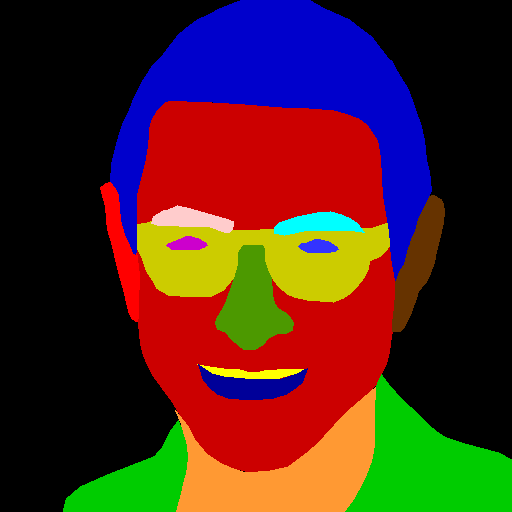

In [184]:
label

In [154]:
label = label.long().numpy()
print(label.dtype)
print(label)

int64
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... 18 18 18]
 [ 0  0  0 ... 18 18 18]
 [ 0  0  0 ... 18 18 18]]


In [158]:
label=label.astype(np.uint8)
print(label)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... 18 18 18]
 [ 0  0  0 ... 18 18 18]
 [ 0  0  0 ... 18 18 18]]


In [162]:
print(label.shape)

(512, 512)


In [163]:
print(np2.shape)

(512, 512)


In [165]:
print(label.dtype)
print(np2.dtype)

uint8
uint8


In [166]:
print(np2)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [18 18 18 ... 18 18 18]
 [18 18 18 ... 18 18 18]
 [18 18 18 ... 18 18 18]]


In [172]:
# second part
bmp = Image.fromarray(np2)
bmp.putpalette(pla)
print(bmp)

<PIL.Image.Image image mode=P size=512x512 at 0x7F451824FA90>


In [174]:
im3 = Image.fromarray(np2)
im3.putpalette(pla)
print(np2)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [18 18 18 ... 18 18 18]
 [18 18 18 ... 18 18 18]
 [18 18 18 ... 18 18 18]]


In [176]:
im3 = Image.fromarray(label)
im3.putpalette(Parameters["PALETTE"])
print(im3)

<PIL.Image.Image image mode=P size=512x512 at 0x7F45181F4A10>


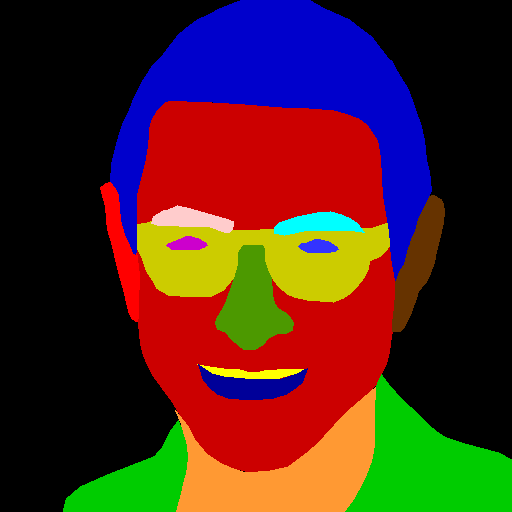

In [177]:
im3

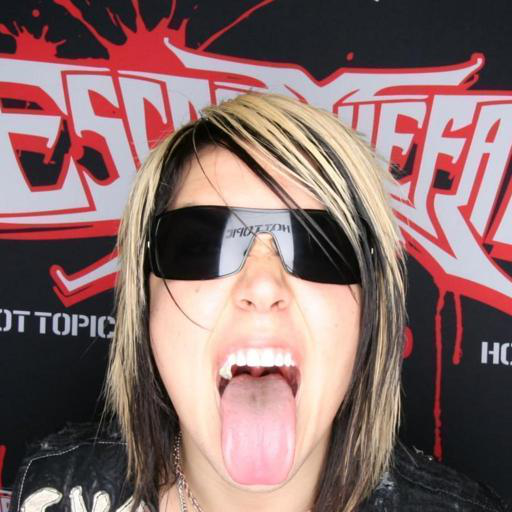

In [109]:
im1 = Image.open(os.path.join(Parameters["TRAIN_PATH"], 'train_image/1.jpg'))
im1

In [113]:
np1 = np.array(im1)
print(np1.shape)

(512, 512, 3)


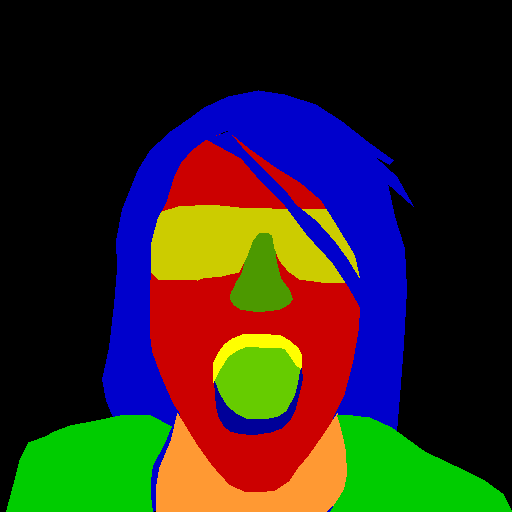

In [111]:
mask1 = Image.open(os.path.join(Parameters["TRAIN_PATH"], 'train_mask/1.png'))
mask1

In [102]:
my_palette = get_my_palette(os.path.join(Parameters["TRAIN_PATH"], 'train_mask/1.png'))
p2 = get_my_palette(os.path.join(Parameters["TRAIN_PATH"], 'train_mask/2.png'))

In [66]:
def read_masks(path):
    mask = Image.open(path)
    mask = np.array(mask)

    return mask

In [72]:
val_path = os.path.join(ROOT, '0.png')
img1 = read_masks(val_path)
print(img1.shape)

(512, 512)


In [69]:
print(Image.open(val_path).mode)

P


In [52]:
size = img1.shape
print(size)

(512, 512)


In [76]:
print(img1)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [18 18 18 ... 18 18 18]
 [18 18 18 ... 18 18 18]
 [18 18 18 ... 18 18 18]]


In [145]:
np2.dtype 

dtype('uint8')

In [ ]:
# second part
bmp = Image.fromarray(np2)
bmp.putpalette(pla)
print(bmp)

In [89]:
img2 = Image.open(os.path.join(ROOT, '0.png')) 
pla = img2.getpalette()

In [91]:
print(pla)

[0, 0, 0, 204, 0, 0, 76, 153, 0, 204, 204, 0, 51, 51, 255, 204, 0, 204, 0, 255, 255, 255, 204, 204, 102, 51, 0, 255, 0, 0, 102, 204, 0, 255, 255, 0, 0, 0, 153, 0, 0, 204, 255, 51, 153, 0, 204, 204, 0, 51, 0, 255, 153, 51, 0, 204, 0, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29, 29, 30, 30, 30, 31, 31, 31, 32, 32, 32, 33, 33, 33, 34, 34, 34, 35, 35, 35, 36, 36, 36, 37, 37, 37, 38, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 43, 43, 43, 44, 44, 44, 45, 45, 45, 46, 46, 46, 47, 47, 47, 48, 48, 48, 49, 49, 49, 50, 50, 50, 51, 51, 51, 52, 52, 52, 53, 53, 53, 54, 54, 54, 55, 55, 55, 56, 56, 56, 57, 57, 57, 58, 58, 58, 59, 59, 59, 60, 60, 60, 61, 61, 61, 62, 62, 62, 63, 63, 63, 64, 64, 64, 65, 65, 65, 66, 66, 66, 67, 67, 67, 68, 68, 68, 69, 69, 69, 70, 70, 70, 71, 71, 71, 72, 72, 72, 73, 73, 73, 74, 74, 74, 75, 75, 75, 76, 76, 76, 77, 77, 77, 78, 78, 78, 79, 79, 79, 80, 80, 80, 81, 81, 81, 82, 82, 82,

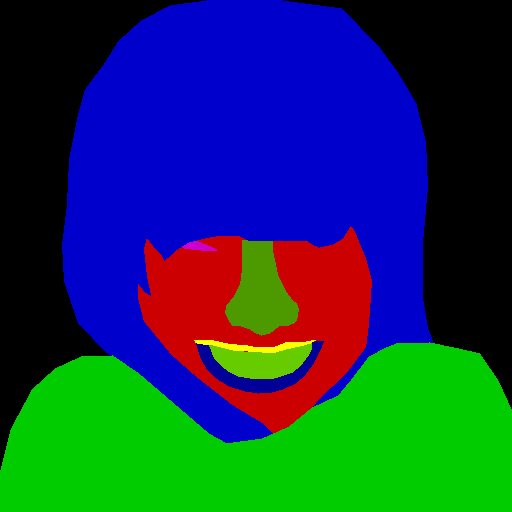

In [93]:
display(img2)

In [ ]:
from IPython.display import Image 

In [81]:
np2 = np.array(img2)
print(np2)
print(np2.shape)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [18 18 18 ... 18 18 18]
 [18 18 18 ... 18 18 18]
 [18 18 18 ... 18 18 18]]
(512, 512)


In [82]:
# second part
bmp = Image.fromarray(np2)
bmp.putpalette(pla)
print(bmp)

<PIL.Image.Image image mode=P size=512x512 at 0x7F4518CCE4D0>


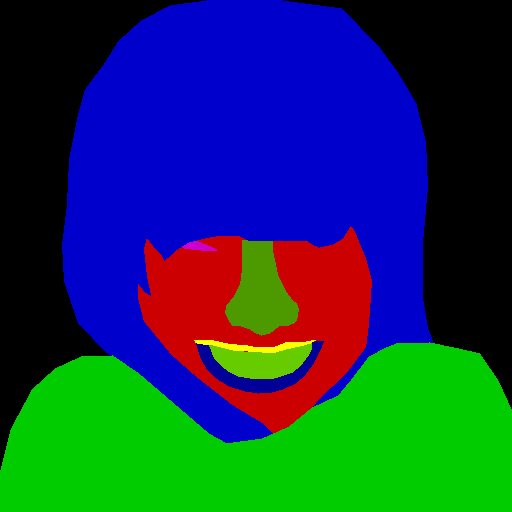

In [106]:
bmp

In [84]:
bmp.save(os.path.join(ROOT, 'hh.png'))

In [73]:
pil_pic = Image.fromarray(img1)
pil_pic.show()

In [75]:
pil_pic.save(ROOT+'hh.png')

In [53]:
oneHot_size = (19, size[0], size[1])
labels_real = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
labels_real = labels_real.scatter_(1, torch.tensor(img1).unsqueeze(0).long().cuda(), 1.0)

In [54]:
print(labels_real.shape)

torch.Size([19, 512, 512])


In [63]:
print(labels_real[0])

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


In [65]:
label_batch_predict = generate_label(labels_real.unsqueeze(0), 512)
print(label_batch_predict[0])

inputshape:  torch.Size([19, 512, 512])
tensor(0., dtype=torch.float64)


In [56]:
print(label_batch_predict.shape)

torch.Size([1, 3, 512, 512])


In [57]:
def save_image(image_numpy, image_path):
    image_pil = Image.fromarray(image_numpy)
    image_pil.save(image_path)

In [62]:
im1 = label_batch_predict.squeeze(0).numpy()
print(im1.shape)
print(im1[2].sum())
#save_image(im1, ROOT+'hh.png')

(3, 512, 512)
0.0


# Dataloader

In [115]:

'''
    mode="train/val/test"
    img.shape: torch.Size([3, 512, 512])
    label.shape: torch.Size([1, 512, 512])
'''
class FaceParse_Dataset(Dataset):
    def __init__(self, img_path, label_path, transform_img, transform_label, mode="train"): 
        self.img_path = img_path
        self.label_path = label_path
        self.transform_img = transform_img
        self.transform_label = transform_label
        self.train_dataset = []
        self.val_dataset = []
        self.test_dataset = []
        self.mode = mode
        self.preprocess()
        
        if mode == "train":
            self.num_images = len(self.train_dataset)
        elif mode == "val":
            self.num_images = len(self.val_dataset)
        else :
            self.num_images = len(self.test_dataset)

    def preprocess(self):
        
        for i in range(len([name for name in os.listdir(self.img_path) if os.path.isfile(os.path.join(self.img_path, name))])):
            img_path = os.path.join(self.img_path, str(i)+'.jpg')
            label_path = os.path.join(self.label_path, str(i)+'.png')
            #print (img_path, label_path) 
            if self.mode == "train":
                self.train_dataset.append([img_path, label_path])
            elif self.mode == "val":
                self.val_dataset.append([img_path, label_path])
            elif self.mode == "test":
                self.test_dataset.append(img_path)
            
        print(f'Finished preprocessing the CelebA dataset in {self.mode} mode...')

    def __getitem__(self, index):
        if self.mode == "test":
            dataset = self.test_dataset
            img_path = dataset[index]
            image = Image.open(img_path)
            return self.transform_img(image)
        else: 
            dataset = self.train_dataset if self.mode == "train" else self.val_dataset
            img_path, label_path = dataset[index]
            image = Image.open(img_path)
            label = Image.open(label_path)
            return self.transform_img(image), self.transform_label(label)

    def __len__(self):
        """Return the number of images."""
        return self.num_images

class Data_Loader():
    def __init__(self, img_path, label_path, image_size, batch_size, mode):
        self.img_path = img_path
        self.label_path = label_path
        self.imsize = image_size
        self.batch = batch_size
        self.mode = mode

    def transform_img(self, resize, totensor, normalize, centercrop):
        options = []
        if centercrop:
            options.append(T.CenterCrop(160))
        if resize:
            options.append(T.Resize((self.imsize,self.imsize)))
        if totensor:
            options.append(T.ToTensor())
        if normalize:
            options.append(T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
        transform = T.Compose(options)
        return transform

    def transform_label(self, resize, totensor, normalize, centercrop):
        options = []
        if centercrop:
            options.append(T.CenterCrop(160))
        if resize:
            options.append(T.Resize((self.imsize,self.imsize)))
        if totensor:
            options.append(T.ToTensor())
        if normalize:
            options.append(T.Normalize((0, 0, 0), (0, 0, 0)))
        transform = T.Compose(options)
        return transform

    def loader(self):
        transform_img = self.transform_img(True, True, True, False) 
        transform_label = self.transform_label(True, True, False, False)  
        dataset = FaceParse_Dataset(self.img_path, self.label_path, transform_img, transform_label, self.mode)

        loader = DataLoader(dataset=dataset,
                            batch_size=self.batch,
                            #shuffle=True,
                            shuffle=(self.mode=="train"),
                            num_workers=2,
                            drop_last=False)
        return loader

In [119]:
# def transform_img(resize, totensor, normalize, centercrop):
#     options = []
#     if centercrop:
#         options.append(T.CenterCrop(160))
#     if resize:
#         options.append(T.Resize((512, 512)))
#     if totensor:
#         options.append(T.ToTensor())
#     if normalize:
#         options.append(T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
#     transform = T.Compose(options)
#     return transform

# def transform_label(resize, totensor, normalize, centercrop):
#     options = []
#     if centercrop:
#         options.append(T.CenterCrop(160))
#     if resize:
#         options.append(T.Resize((512, 512)))
#     if totensor:
#         options.append(T.ToTensor())
#     if normalize:
#         options.append(T.Normalize((0, 0, 0), (0, 0, 0)))
#     transform = T.Compose(options)
#     return transform

In [ ]:
#test

In [120]:
# transform_img = transform_img(False, True, True, False) 
# transform_label = transform_label(False, True, False, False)  
# train_dataset = FaceParse_Dataset(train_img_path, train_label_path, transform_img, transform_label, "train")

# loader = DataLoader(dataset=train_dataset,
#                     batch_size=8,
#                     #shuffle=True,
#                     shuffle=False,
#                     num_workers=2,
#                     drop_last=False)

Finished preprocessing the CelebA dataset in train mode...


In [40]:
# sam = 0
# img, label = train_dataset[sam]
# print(img.shape)
# print(label.shape)

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])


# Trainer

In [ ]:
class Trainer(object):
    def __init__(self, train_loader, val_loader, config):

        # Data loader
        self.train_loader = train_loader
        self.val_loader = val_loader

        # exact model and loss
        self.model = config["MODEL"]

        # Model hyper-parameters
        self.imsize = config["IMSIZE"]
        #self.parallel = config.parallel

        self.num_epoch = config["NUM_EPOCH"]
        self.start_epoch = config["START_EPOCH"]
        self.train_batch_size = config["TRAIN_BATCH_SIZE"]
        self.val_batch_size = config["VAL_BATCH_SIZE"]
        #self.num_workers = config.num_workers
        self.g_lr = config["LEARNING_RATE"]
        self.lr_decay = config["LR_DECAY"]
        self.beta1 = config["BETA1"]
        self.beta2 = config["BETA2"]
        self.model = config["MODEL"]
        self.device = config["MODEL"]

        self.num_classes = config["NUM_CLASSES"]
        #self.pretrained_model = config.pretrained_model

        # self.use_tensorboard = config.use_tensorboard
        # self.img_path = config.img_path
        # self.label_path = config.label_path 
        # self.log_path = config.log_path
        # self.model_save_path = config.model_save_path
        # self.sample_path = config.sample_path
        # self.log_step = config.log_step
        # self.sample_step = config.sample_step
        # self.model_save_step = config.model_save_step
        # self.version = config.version

        # # Path
        # self.log_path = os.path.join(config.log_path, self.version)
        # self.sample_path = os.path.join(config.sample_path, self.version)
        # self.model_save_path = os.path.join(config.model_save_path, self.version)

        #self.build_model()

        # if self.use_tensorboard:
        #     self.build_tensorboard()

        # Start with trained model
        # if self.pretrained_model:
        #     self.load_pretrained_model()

    def train(self):

        
        for epoch in range(self.start_epoch, self.start_epoch+ self.num_epoch):
            self.model.train()

            train_loss_sum = 0
            train_miou_sum = 0
            train_num = 0

            val_loss_sum = 0
            val_miou_sum = 0
            val_num = 0

            # train
            with tqdm(total=len(self.train_loader), desc="training progress bar") as progress_bar:
                progress_bar.set_description('Epoch: {}/{} training'.format(epoch, self.start_epoch+ self.num_epoch ))
                for batch, (imgs, labels) in enumerate(self.train_loader):
                    imgs, labels = imgs.to(self.device), imgs.to(self.device)

                    # Forward
                    outputs = self.model(imgs)

                    # labels.shape: [batch_size, 1, imsize, imsize], *255 is because ToTensor() has / 255.
                    labels[:, 0, :, :] = labels[:, 0, :, :] * 255.0
                    labels_real_plain = labels[:, 0, :, :]

                    # compute loss
                    loss = cross_entropy2d(outputs, labels_real_plain.long())



                    self.optimizer.zero_grad()







        # Data iterator
        data_iter = iter(self.data_loader)
        step_per_epoch = len(self.data_loader)
        model_save_step = int(self.model_save_step * step_per_epoch)

        # Start with trained model
        if self.pretrained_model:
            start = self.pretrained_model + 1
        else:
            start = 0

        # Start time
        start_time = time.time()
        for step in range(start, self.total_step):

            self.G.train()
            try:
                imgs, labels = next(data_iter)
            except:
                data_iter = iter(self.data_loader)
                imgs, labels = next(data_iter)

            size = labels.size()
            labels[:, 0, :, :] = labels[:, 0, :, :] * 255.0
            labels_real_plain = labels[:, 0, :, :].cuda()
            labels = labels[:, 0, :, :].view(size[0], 1, size[2], size[3])
            oneHot_size = (size[0], 19, size[2], size[3])
            labels_real = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
            labels_real = labels_real.scatter_(1, labels.data.long().cuda(), 1.0)

            imgs = imgs.cuda()
            # ================== Train G =================== #
            labels_predict = self.G(imgs)
                       
            # Calculate cross entropy loss
            c_loss = cross_entropy2d(labels_predict, labels_real_plain.long())
            self.reset_grad()
            c_loss.backward()
            self.g_optimizer.step()

            # Print out log info
            if (step + 1) % self.log_step == 0:
                elapsed = time.time() - start_time
                elapsed = str(datetime.timedelta(seconds=elapsed))
                print("Elapsed [{}], G_step [{}/{}], Cross_entrophy_loss: {:.4f}".
                      format(elapsed, step + 1, self.total_step, c_loss.data))

            label_batch_predict = generate_label(labels_predict, self.imsize)
            label_batch_real = generate_label(labels_real, self.imsize)

            # scalr info on tensorboardX
            writer.add_scalar('Loss/Cross_entrophy_loss', c_loss.data, step) 

            # image infor on tensorboardX
            img_combine = imgs[0]
            real_combine = label_batch_real[0]
            predict_combine = label_batch_predict[0]
            for i in range(1, self.batch_size):
                img_combine = torch.cat([img_combine, imgs[i]], 2)
                real_combine = torch.cat([real_combine, label_batch_real[i]], 2)
                predict_combine = torch.cat([predict_combine, label_batch_predict[i]], 2)
            writer.add_image('imresult/img', (img_combine.data + 1) / 2.0, step)
            writer.add_image('imresult/real', real_combine, step)
            writer.add_image('imresult/predict', predict_combine, step)

            # Sample images
            if (step + 1) % self.sample_step == 0:
                labels_sample = self.G(imgs)
                labels_sample = generate_label(labels_sample)
                labels_sample = torch.from_numpy(labels_sample)
                save_image(denorm(labels_sample.data),
                           os.path.join(self.sample_path, '{}_predict.png'.format(step + 1)))

            if (step+1) % model_save_step==0:
                torch.save(self.G.state_dict(),
                           os.path.join(self.model_save_path, '{}_G.pth'.format(step + 1)))
    
    def build_model(self):

        self.G = unet().cuda()
        if self.parallel:
            self.G = nn.DataParallel(self.G)

        # Loss and optimizer
        self.g_optimizer = torch.optim.Adam(self.G.parameters(), self.g_lr, [self.beta1, self.beta2])
        self.g_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.G.parameters()), self.g_lr, [self.beta1, self.beta2])

        # print networks
        print(self.G)

    def build_tensorboard(self):
        from logger import Logger
        self.logger = Logger(self.log_path)

    def load_pretrained_model(self):
        self.G.load_state_dict(torch.load(os.path.join(
            self.model_save_path, '{}_G.pth'.format(self.pretrained_model))))
        print('loaded trained models (step: {})..!'.format(self.pretrained_model))

    def reset_grad(self):
        self.g_optimizer.zero_grad()

    def save_sample(self, data_iter):
        real_images, _ = next(data_iter)
        save_image(denorm(real_images), os.path.join(self.sample_path, 'real.png'))

    def valid(self, epoch, log_images=False, batch_idx=0):
        "Compute performance of the model on the validation dataset and log a wandb.Table"
        self.model.eval()
        val_loss = 0.
        val_miou = 0.
        total_num = 0

        with torch.inference_mode():
            with tqdm(total=len(val_loader), desc="validating progress bar") as progress_bar:
                progress_bar.set_description('epoch: {}/{} validating'.format(epoch, self.start_epoch+ self.num_epoch))

                for batch, (imgs, labels) in enumerate(self.val_loader):
                    # imgs: [batch, 3, imsize, imsize]
                    # labels: [batch, 1, imsize, imsize]
                    imgs, labels = imgs.to(self.device), labels.to(self.device)
                    # outputs: [batch, num_class, imsize, imsize]
                    outputs = self.model(imgs)
                    # *255 to restore the real pixel value (transform.ToTensor has / 255)
                    labels[:, 0, :, :] = labels[:, 0, :, :] * 255.0
                    # labels_real_plain: [batch, imsize, imsize]
                    labels_real_plain = labels[:, 0, :, :]
                    # compute loss (average loss over one batch)
                    loss = cross_entropy2d(outputs, labels_real_plain.long())
                    val_loss += loss.item() * imgs.size(0)
                    # compute miou
                    # pred_mask: [batch, imsize, imsize]
                    pred_mask = torch.argmax(outputs, dim=1)
                    val_miou += get_miou(pred_mask, labels_real_plain, num_classes=self.num_classes)
                    # count total_num
                    total_num += imgs.size(0)

                    # Log one batch of images to the dashboard, always same batch_idx.
                    if epoch % 10 == 0 and batch==batch_idx and log_images:
                        wandb_log_image_table(images, predicted, labels, outputs.softmax(dim=1))

                    # update progress_bar
                    progress_bar.set_postfix(miou="{:.2f}%".format(val_miou / total_num),
                                              loss='{:.5f}'.format(val_loss / total_num))
                    progress_bar.update(1)

        return val_loss / len(self.val_loader), val_miou / len(self.val_loader)



# Main

In [191]:
Parameters = {
    "MODEL_VERSION": '1.1',
    "NUM_EPOCH": 100,
    "START_EPOCH": 0,
    "NUM_CLASSES": 19,
    "IMSIZE": 512,
    "TRAIN_BATCH_SIZE": 8,    # input batch size for training (default: 64)
    "VAL_BATCH_SIZE": 16,    # input batch size for testing (default: 1000)
    #"TRAIN_EPOCHS": 51,        # number of epochs to train (default: 10)
    #"SEED": 42,               # random seed (default: 42)


    # Model Para
    "LEARNING_RATE": 1e-4 ,   # learning rate (default: 0.01)
    "LR_DECAY": 0.95,
    "BETA1": 0.5,
    "BETA2": 0.999,

    # Path
    #'train_image_path': os.path.join(ROOT, 'train'),
    "TRAIN_PATH": os.path.join(ROOT, 'train'),
    "VAL_PATH": os.path.join(ROOT, 'val'),
    "TEST_PATH": os.path.join(ROOT, 'test'),
    "DEVICE": DEVICE,

    #'train_label_path': '/content/train/train_mask/',
    #'val_image_path': '/content/val/val_image/',
    #'val_label_path': '/content/val/val_mask/',
}
Parameters["PALETTE"] = get_my_palette(os.path.join(Parameters["TRAIN_PATH"], 'train_mask/1.png'))

In [192]:
# Parameters = {
#     "MODEL_VERSION": '1.1',
#     "NUM_EPOCH": 100,
#     "START_EPOCH": 0,
#     "NUM_CLASSES": 19,
#     "IMSIZE": 512,
#     "TRAIN_BATCH_SIZE": 8,    # input batch size for training (default: 64)
#     "VAL_BATCH_SIZE": 16,    # input batch size for testing (default: 1000)
#     #"TRAIN_EPOCHS": 51,        # number of epochs to train (default: 10)e
#     #"SEED": 42,               # random seed (default: 42)


#     # Model Para
#     "LEARNING_RATE": 1e-4 ,   # learning rate (default: 0.01)
#     "LR_DECAY": 0.95,
#     "BETA1": 0.5,
#     "BETA2": 0.999,

#     # Path
#     #'train_image_path': os.path.join(ROOT, 'train'),
#     "TRAIN_PATH": os.path.join(ROOT, 'train'),
#     "VAL_PATH": os.path.join(ROOT, 'val'),
#     "TEST_PATH": os.path.join(ROOT, 'test'),
#     "DEVICE": DEVICE,

#     #'train_label_path': '/content/train/train_mask/',
#     #'val_image_path': '/content/val/val_image/',
#     #'val_label_path': '/content/val/val_mask/',
# }

with wandb.init(
    config = Parameters,
    project="Face_Parsing"+ Parameters["MODEL_VERSION"],
    ):
    config = wandb.config
    

    train_img_path = os.path.join(config["TRAIN_PATH"], 'train_image')
    train_label_path = os.path.join(config["TRAIN_PATH"], 'train_mask')
    val_img_path = os.path.join(config["VAL_PATH"], 'val_image')
    val_label_path = os.path.join(config["VAL_PATH"], 'val_mask')
    test_img_path = os.path.join(config["TEST_PATH"], 'test_image')
    
    # train_loader: img([8, 3, 512, 512]), label([8, 1, 512, 512])
    train_loader = Data_Loader(train_img_path, train_label_path, \
                  config["IMSIZE"], config["TRAIN_BATCH_SIZE"], "train").loader()
    val_loader = Data_Loader(val_img_path, val_label_path, \
                  config["IMSIZE"], config["VAL_BATCH_SIZE"], "val").loader()




    #trainer = Trainer(data_loader.loader(), config)
    #trainer.train()

Finished preprocessing the CelebA dataset in train mode...
Finished preprocessing the CelebA dataset in val mode...

